# 03 Введение в Softmax алгоритм

У алгоритма epsilon-Greedy есть очевидная проблема: он перебирает варианты совершенно наугад, не задумываясь об их достоинствах. 

Например, в одном сценарии (назовем его сценарием A) у вас может быть две руки, одна из которых вознаграждает вас в 10 % случаев, а другая - в 13 % случаев. В сценарии B эти две руки могут вознаграждать вас в 10 % случаев и в 99 % случаев. В обоих этих сценариях вероятность того, что алгоритм epsilon-Greedy найдет худшую руку, одинакова (она равна epsilon / 2), несмотря на то, что худшая рука в сценарии B в относительном выражении гораздо хуже худшей руки в сценарии A.
Это проблема по нескольким причинам:
- Если разница в наградах между двумя руками невелика, вам придется исследовать их гораздо чаще, чем в 10% случаев, чтобы правильно определить, какой из двух вариантов на самом деле лучше.
- Напротив, если разница велика, вам нужно исследовать гораздо меньше, чем 10 % времени, чтобы правильно оценить лучший из двух вариантов. По этой причине, исследуя однозначно худший вариант, вы в конечном итоге потеряете много вознаграждения. Когда мы впервые описывали алгоритм epsilon-Greedy, мы говорили, что не будем задавать epsilon = 1.0 именно для того, чтобы не тратить время на плохие варианты, но если разница между двумя руками достаточно велика, мы в итоге тратим время на плохие варианты просто потому, что алгоритм epsilon-Greedy всегда исследует совершенно случайным образом.





Если сложить эти два момента вместе, становится ясно, что алгоритму epsilon-Greedy не хватает качественного свойства. Нам нужно сделать так, чтобы алгоритм бандита заботился об известных различиях между оценочными значениями рук, когда алгоритм решает, какую руку исследовать. Нам нужно структурированное исследование, а не бессистемное, которое обеспечивает алгоритм epsilon-Greedy.

Первый алгоритм, который мы опишем и который учитывает эту структурную информацию, называется алгоритмом Softmax. Алгоритм Softmax пытается справиться с руками, отличающимся по выигрышу, путем явного включения информации о вознаграждения доступных рук в свой метод выбора руки, которую следует выбрать при исследовании.

Вы можете получить начальное представление о том, как алгоритм Softmax справляется с этой проблемой, представив, что вы выбираете каждую руку пропорционально ее вознаграждению. 

Предположим, что у вас есть две руки, A и B. Теперь представьте, что, исходя из вашего прошлого опыта, эти две руки имели два разных коэффициента успеха: rA и rB. При таких предположениях самая наивная возможная реализация Softmax-подобного алгоритма заставит вас выбрать руку A с вероятностью rA / (rA + rB), а руку B - с вероятностью rB / (rA + rB). В коде этот пропорциональный подход будет выглядеть так:w(probs)
```



In [1]:
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

def select_arm(self):
    z = sum(self.values)
    probs = [v / z for v in self.values]
    return categorical_draw(probs)

На практике этот очень наивный алгоритм не используется людьми. Чтобы воссоздать алгоритм, который люди используют на самом деле, нам нужно внести в него два изменения.

Во-первых, мы рассчитаем другую шкалу для вознаграждения, экспоненцировав наши оценки rA и rB. Используя эту новую шкалу, мы будем выбирать руку A с вероятностью exp(rA) / (exp(rA) + exp(rB)) и руку B с вероятностью exp(rB) / (exp(rA) + exp(rB)). Это наивное экспоненциальное пересчитывание имеет то преимущество, что оно не ведет себя странно, если вы используете отрицательные числа в качестве коэффициентов успеха, поскольку обращение к exp превращает любые отрицательные числа в положительные и гарантирует, что отрицательные числа в знаменателе этих дробей не смогут аннулировать положительные числа, которые могут быть найдены в знаменателе.

Что еще более важно, этот трюк с экспонентой очень близко подводит нас к полному алгоритму Softmax. Фактически, простое экспоненциальное масштабирование дает нам алгоритм Softmax, если вы жестко закодируете один из настраиваемых параметров, которыми обладает стандартный алгоритм Softmax. 
      
Этот новый тип фактора масштабирования обычно называют температурным параметром по аналогии с физикой, в которой системы при высоких температурах ведут себя хаотично, а при низких температурах приобретают большую структуру. На самом деле, полный алгоритм Softmax тесно связан с концепцией распределения Больцмана в физике, которая используется для описания поведения групп частиц.





Мы назовем этот новый температурный параметр tau. Мы вводим tau, чтобы создать следующий новый алгоритм:
- В момент времени T выбираем одна из двух рук с вероятностью, вычисляемой следующим образом:
    - exp(rA / tau) / (exp(rA / tau) + exp(rB / tau))
    - exp(rB / tau) / (exp(rA / tau) + exp(rB / tau))
- Для каждой выбранной руки обновляется оценка среднего, используя то же правило обновления, которое мы использовали для жадного алгоритма.

# Реализация алгоритма Softmax

Объединив эти новые идеи, мы получим следующий код для полного алгоритма Softmax:

In [2]:
import math
import random

def ind_max(x):
    m = max(x)
    return x.index(m)

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
  
    return len(probs) - 1

class Softmax:
    def __init__(self, temperature, counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values
  
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
  
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

Теперь, когда мы полностью описали и реализовали алгоритм Softmax, нам следует уделить некоторое время обсуждению того, что делает температурный параметр tau. 

Проще всего думать, что tau позволяет нам изменять поведение алгоритма Softmax на континууме, определяемом двумя крайними способами выбора руки. В одном случае мы задаем tau = 0,0. Это даст нам полностью детерминированный выбор руки, имеющей наибольшее вознаграждение.

В другом крайнем случае мы зададим tau = Inf, что даст нам чисто случайный поиск, как в алгоритме epsilon-Greedy. Причина, по которой этот параметр tau называется температурным, заключается в том, что его влияние на выбор руки похоже на влияние температуры на атомы в традиционной физике: при низких температурах атомы ведут себя упорядоченно и создают твердые тела, а при высоких температурах они ведут себя беспорядочно и создают газы. Как и атомы, алгоритм Softmax при низких температурах ведет себя упорядоченно, а при высоких температурах - по сути, беспорядочно.

Теперь, когда вы поняли основную идею алгоритма Softmax, давайте опробуем его в тех же симулированных сценариях, в которых мы ранее тестировали алгоритм epsilon-greedy.

In [3]:
def test_algorithm(algo, arms, num_sims, horizon):
    '''
    algo:
    arms:
    num_sims:
    horizon:
    '''
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [4]:
class BernoulliArm:
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [5]:
import random

random.seed(1)
means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means)))

f = open("standard_softmax_results.tsv", "w")

for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    for i in range(len(results[0])):
        f.write(str(temperature) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()

Best arm is 1


# Анализ результатов исследования методом Монте-Карло

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('standard_softmax_results.tsv', sep='\t', header=None)
df.columns = ['temperature', 'sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards']

## Подход 1: отслеживание вероятности выбора лучшей руки

In [8]:
import matplotlib.pyplot as plt

In [9]:
kk = df[(df['chosen_arms']==1)].groupby(['temperature', 'times', 'chosen_arms']).size().reset_index()
kk.columns = ['temperature', 'times', 'chosen_arms', 'count']
kk['proba'] = kk['count']/5000

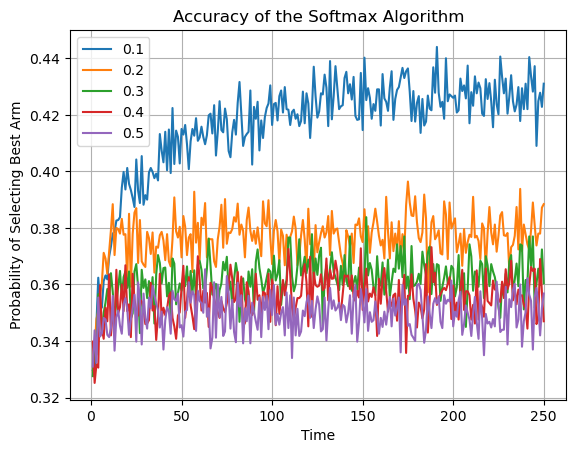

In [10]:
plt.plot(kk['times'][kk['temperature'] == 0.1], kk['proba'][kk['temperature'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['temperature'] == 0.2], kk['proba'][kk['temperature'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['temperature'] == 0.3], kk['proba'][kk['temperature'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['temperature'] == 0.4], kk['proba'][kk['temperature'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['temperature'] == 0.5], kk['proba'][kk['temperature'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.title('Accuracy of the Softmax Algorithm')
plt.legend()
plt.grid()
plt.show()

Если посмотреть на вероятность того, что алгоритм softmax выберет верную руку, то мы увидим, что он начинает выбирать верную руку в 100 % случаев, если мы ждем достаточно долго. Это большое улучшение по сравнению с алгоритмом epsilon-Greedy, который так и не смог преодолеть внутренние ошибки, вызванные чисто случайной стратегией поиска. В нашем стандартном тестовом примере есть одна выделяющаяся рука, и алгоритм softmax способен найти ее и использовать гораздо эффективнее, чем алгоритм epsilon-Greedy.

## Подход 2: отслеживание среднего вознаграждения в каждый момент времени

In [11]:
kk = df.groupby(['temperature', 'times']).mean().reset_index()

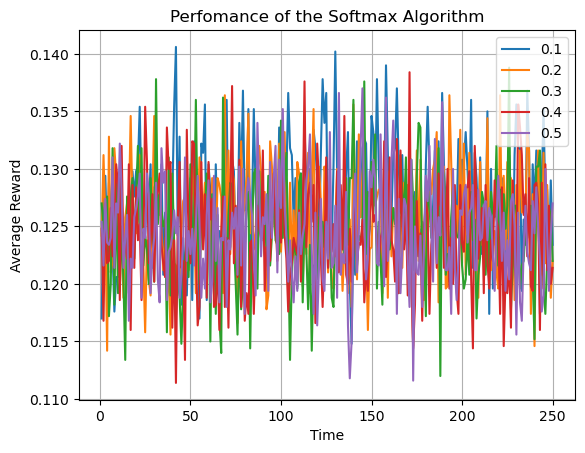

In [12]:
plt.plot(kk['times'][kk['temperature'] == 0.1], kk['rewards'][kk['temperature'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['temperature'] == 0.2], kk['rewards'][kk['temperature'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['temperature'] == 0.3], kk['rewards'][kk['temperature'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['temperature'] == 0.4], kk['rewards'][kk['temperature'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['temperature'] == 0.5], kk['rewards'][kk['temperature'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Perfomance of the Softmax Algorithm')
plt.legend()
plt.grid()
plt.show()

Мы видим те же результаты, глядя на средние показатели вознаграждения, показанные на рисунке, за исключением того, что вознаграждение ограничено на уровне 0,9 вместо 1,0, поскольку 0,9 - это ожидаемый уровень вознаграждения, связанный с лучшей рукой в нашем тестовом наборе.

## Подход 3: отслеживание совокупного вознаграждения в каждый момент времени

In [13]:
kk = df.groupby(['temperature', 'times']).mean().reset_index()

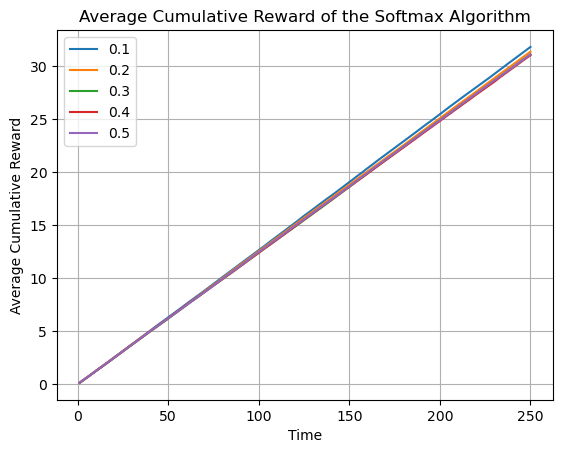

In [14]:
plt.plot(kk['times'][kk['temperature'] == 0.1], kk['cumulative_rewards'][kk['temperature'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['temperature'] == 0.2], kk['cumulative_rewards'][kk['temperature'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['temperature'] == 0.3], kk['cumulative_rewards'][kk['temperature'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['temperature'] == 0.4], kk['cumulative_rewards'][kk['temperature'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['temperature'] == 0.5], kk['cumulative_rewards'][kk['temperature'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward of the Softmax Algorithm')
plt.legend()
plt.grid()
plt.show()

Наконец, мы можем получить более полное представление о различных настройках температуры, если посмотрим на накопленные награды, как показано на рисунке. На этом рисунке видно, что самый низкий температурный режим, который мы использовали, 0.1, дает лучшие результаты почти с самого начала. Это типично для условий, в которых существуют четкие различия между руками. Гораздо менее вероятно, что низкий уровень исследования, который мы наблюдаем при температуре 0.1 в Softmax, будет идеальным, если руки расположены ближе друг к другу.

# Алгоритм отжига Softmax (The Annealing Softmax Algorithm)

Как мы уже упоминали, **часто бывает полезно поощрять алгоритм к тому, чтобы он меньше исследовал с течением времени**. В алгоритме Softmax мы можем добиться этого, медленно снижая температуру, что мы называем отжигом. 

Название "отжиг" основано на метафоре о кузнечном деле. Для кузнеца отжиг - это процесс, при котором он медленно снижает температуру, при которой работает с расплавом, чтобы он стал более твердым и менее гибким. Это помогает создавать более прочные материалы, поскольку металл становится ближе к своей окончательной, желаемой форме.

Для бандитских алгоритмов мы можем снизить температуру, изменив параметр температуры. Это заставит наш алгоритм чаще использовать лучшую руку и перейти к окончательной детерминированной стратегии выбора руки.

Но прежде чем мы пойдем дальше, давайте дадим два эквивалентных определения термина "отжиг":
- Отжиг - это процесс уменьшения температуры в алгоритме Softmax с течением времени.
- **Отжиг - это процесс изменения поведения алгоритма бандита таким образом, чтобы он меньше исследовал с течением времени**.

Почему эти определения - одно и то же? Первое определение на самом деле является частным случаем второго определения, потому что алгоритм Softmax будет исследовать меньше с течением времени, если мы уменьшим температурный параметр tau. Таким образом, наш алгоритм отжига на самом деле будет стратегией медленного понижения температуры с течением времени. Ниже мы реализуем полную стратегию отжига, основанную на двух простых строках кода:

```python
t = sum(self.counts) + 1
temperature = 1 / math.log(t + 0.0000001)
```

Что здесь происходит? Проще всего понять эту строку, представив, что происходит при t = 1. В этом случае мы задаем температуру = 1 / math.log(1.0000001), что очень близко к бесконечности. Таким образом, температура чрезвычайно высока, и система будет исследоваться почти полностью случайным образом.

Но по мере увеличения t температура будет становиться все ниже и ниже. Поскольку мы используем логарифмы, это снижение не является чрезвычайно быстрым: скорее, оно достаточно быстрое, чтобы быть эффективным. Такое деление на логарифмически масштабированную версию t не всегда является лучшим подходом к отжигу.

In [15]:
import math
import random

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
  
    return len(probs) - 1

class AnnealingSoftmax:
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
  
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
  
    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001)

        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [16]:
import random

random.seed(1)
means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means)))

algo = AnnealingSoftmax([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)

f = open("annealing_softmax_results.tsv", "w")

for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()

Best arm is 1


# Анализ результатов исследования

In [17]:
df = pd.read_csv('annealing_softmax_results.tsv', sep='\t', header=None)
df.columns = ['sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards']

## Подход 1: отслеживание вероятности выбора лучшей руки

In [18]:
kk = df[(df['chosen_arms']==1)].groupby(['times', 'chosen_arms']).size().reset_index()
kk.columns = ['times', 'chosen_arms', 'count']
kk['proba'] = kk['count']/5000

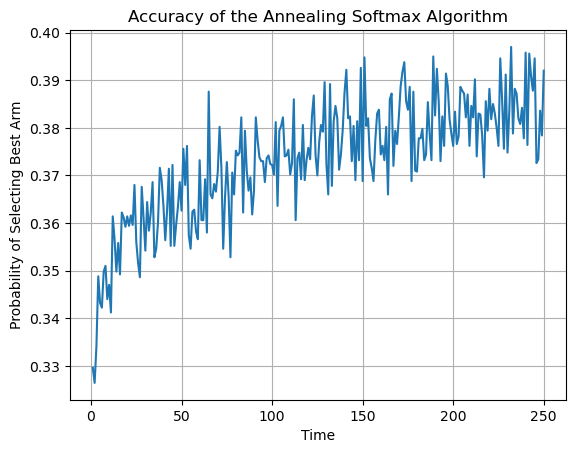

In [19]:
plt.plot(kk['times'], kk['proba'])

plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.title('Accuracy of the Annealing Softmax Algorithm')
plt.grid()
plt.show()

## Подход 2: отслеживание среднего вознаграждения в каждый момент времени

In [20]:
kk = df.groupby(['times']).mean().reset_index()

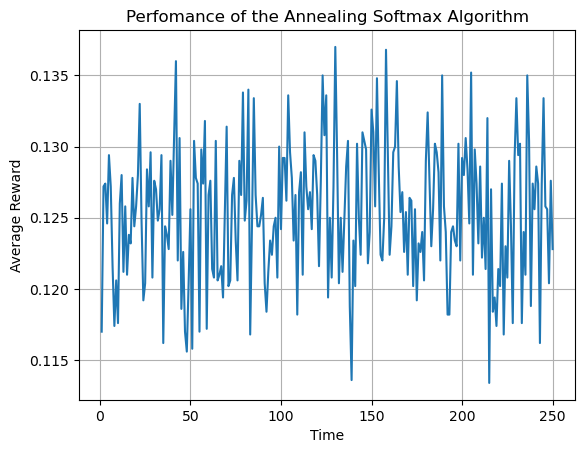

In [21]:
plt.plot(kk['times'], kk['rewards'])

plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Perfomance of the Annealing Softmax Algorithm')
plt.grid()
plt.show()

## Подход 3: отслеживание совокупного вознаграждения в каждый момент времени

In [22]:
kk = df.groupby(['times']).mean().reset_index()

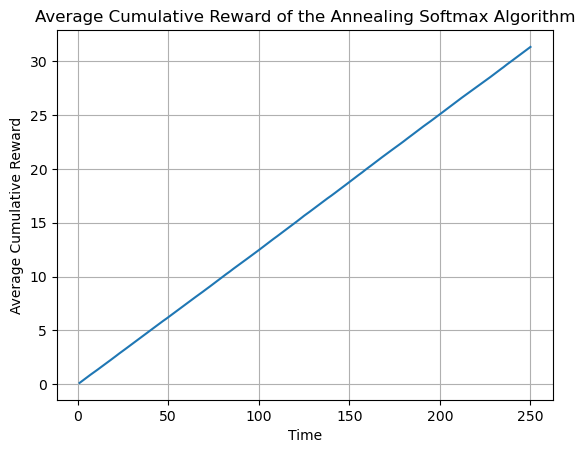

In [23]:
plt.plot(kk['times'], kk['cumulative_rewards'])
plt.xlabel('Time')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward of the Annealing Softmax Algorithm')
plt.grid()
plt.show()

Как видно из этих графиков, система достигает идеальной производительности не так быстро, как лучшая из наших жестко заданных температурных настроек в предыдущем наборе графиков. Но алгоритм достигает пика производительности гораздо быстрее, чем худший из наших вариантов настроек, и достигает более высокого пика. 

Во многих отношениях действительно важен тот факт, что наши дела идут не намного хуже, чем в нашем лучшем случае, потому что мы знали, какая настройка температуры лучше всего, только постфактум: на практике нам пришлось бы экспериментировать с различными настройками температуры, чтобы найдите тот, который будет хорошо работать.

Это нетривиальная задача для системы, которую нужно развернуть в реальном мире, чтобы полностью протестировать, поэтому использование отжига может стать реальным улучшением. Вы всегда должны стараться избегать необходимости использовать свою интуицию для установки любых параметров, которые могут повлиять на алгоритм бандита, когда он будет развернут в реальном мире.

# Упражнения

Чтобы улучшить ваше понимание алгоритма Softmax и его варианта отжига, мы предлагаем вам попробовать выполнить следующие задания:

- Посмотрите, что произойдет с алгоритмом Softmax, если ему придется исследовать набор рук, которые все очень похожи друг на друга и ни одна из которых не выделяется из общей массы. Вместо нашего использования means = [0.1, 0.1, 0.1, 0.1, 0.1, 0.9], попробуйте использовать means = [0.1, 0.1, 0.1, 0.1, 0.12]. Исчезает ли разительная разница между Softmax и epsilon-Greedy при изменении параметров этих двух алгоритмов?

- Можете ли вы найти настройки epsilon для алгоритма epsilon-Greedy и температуры для алгоритма Softmax, которые наиболее близки к подражанию друг другу на фиксированном наборе рук? Что мешает этим двум алгоритмам вести себя одинаково?

- Мы использовали одно конкретное правило отжига, когда заставляли алгоритм Softmax уменьшать заданную температуру с течением времени. Что произойдет, если использовать другое правило, например temperature = 1.0 / t? Что произойдет, если изменять этот параметр по блокам игр так, чтобы температура = 0,5 для первых 100 раундов, а затем температура = 0,1 для следующих 100 раундов? Существуют ли общие стратегии настройки этих параметров, которые, как кажется, хорошо работают?